# Binary Logistic Regression
Using Iris


In [182]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import blackjax
import bayeux as bx
import warnings

from matplotlib.lines import Line2D

warnings.simplefilter(action="ignore", category=FutureWarning)

In [183]:
SEED = 1234
az.style.use("arviz-darkgrid")

## The iris dataset

Next, we will look at the classic "iris" dataset, which contains samples from 3 different species of iris plants. Using properties of the plant, we will try to model its species.

In [184]:
iris = sns.load_dataset("iris")
df=iris.query("species != 'virginica'")
df=df.sample(20000, replace=True)


# Define the noise factor (percentage of labels to be misplaced)
noise_factor = 0.01  # 10% of the labels will be misplaced
# Get the number of samples to misplace
num_samples_to_misplace = int(len(df) * noise_factor)
# Get the indices to misplace
indices_to_misplace = np.random.choice(df.index, size=num_samples_to_misplace, replace=False)
# Shuffle the species labels for the selected indices
df.loc[indices_to_misplace, 'species'] = np.random.permutation(df.loc[indices_to_misplace, 'species'])


from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df, test_size=0.5, random_state=42)
df

,sepal_length,sepal_width,petal_length,petal_width,species
88,5.6,3.0,4.1,1.3,setosa
25,5.0,3.0,1.6,0.2,versicolor
61,5.9,3.0,4.2,1.5,versicolor
35,5.0,3.2,1.2,0.2,setosa
74,6.4,2.9,4.3,1.3,setosa
...,...,...,...,...,...
43,5.0,3.5,1.6,0.6,setosa
12,4.8,3.0,1.4,0.1,setosa
60,5.0,2.0,3.5,1.0,setosa
62,6.0,2.2,4.0,1.0,versicolor


In [185]:
df['species'].value_counts()

species
versicolor    5134
setosa        4866
Name: count, dtype: int64

In [186]:
model = bmb.Model(
    "species ~ sepal_length + sepal_width + petal_length + petal_width", 
    df, 
    family="bernoulli",
)

In [187]:
model

       Formula: species ~ sepal_length + sepal_width + petal_length + petal_width
        Family: bernoulli
          Link: p = logit
  Observations: 10000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 27.6216)
            sepal_length ~ Normal(mu: 0.0, sigma: 3.9126)
            sepal_width ~ Normal(mu: 0.0, sigma: 5.2088)
            petal_length ~ Normal(mu: 0.0, sigma: 1.7309)
            petal_width ~ Normal(mu: 0.0, sigma: 4.439)

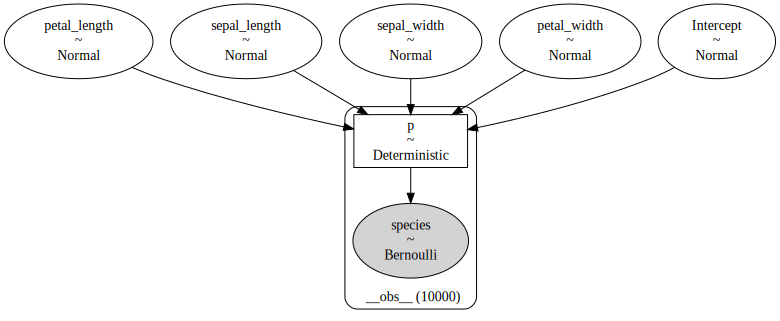

In [188]:
model.build()
model.graph()

In [189]:
methods = bmb.inference_methods.names
methods

{'pymc': {'mcmc': ['mcmc'], 'vi': ['vi']}, 'bayeux': {'mcmc': []}}

In [190]:
import time
# Record the start time
start_time = time.time()

#fit model
idata = model.fit()

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

# Print the duration
print(f"Time taken: {duration} seconds")

Modeling the probability that species==setosa
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sepal_length, sepal_width, petal_length, petal_width]


Output()

ValueError: Not enough samples to build a trace.

In [151]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.606,1.543,-7.506,-1.770,0.024,0.018,4042.0,2238.0,1.0
petal_length,-1.172,0.435,-2.000,-0.377,0.011,0.008,1476.0,1891.0,1.0
petal_width,-4.044,0.961,-5.937,-2.327,0.022,0.015,1954.0,2172.0,1.0
sepal_length,2.229,0.461,1.338,3.064,0.011,0.008,1835.0,2121.0,1.0
sepal_width,-0.421,0.399,-1.128,0.374,0.009,0.007,1852.0,1880.0,1.0


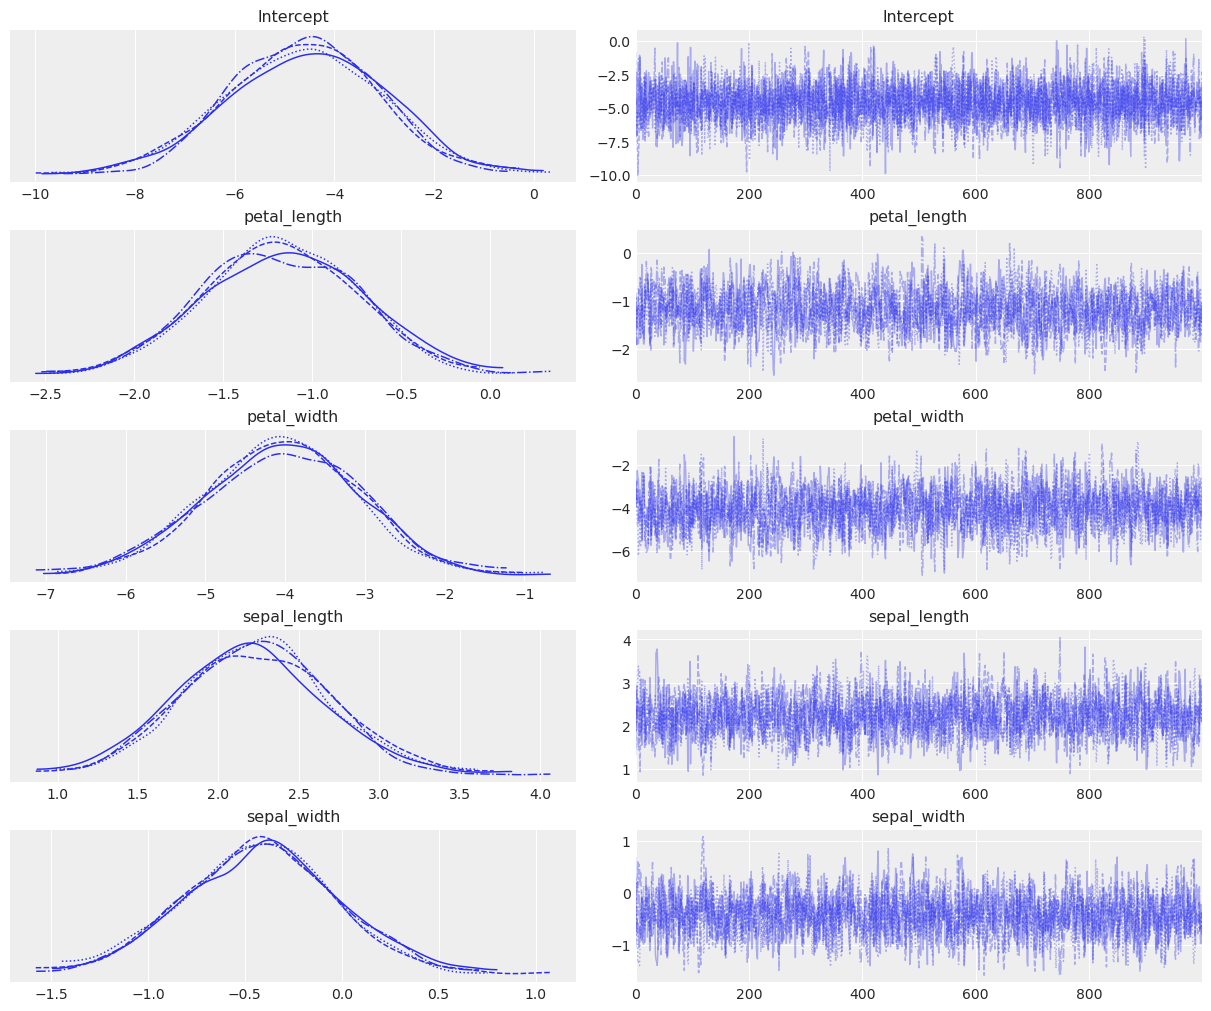

In [152]:
az.plot_trace(idata);

We can see that this has fit quite nicely. In this case, recall there's only one parameter set, since it models probability $p$ of being in a class, and probability $1-p$ of being in the other class. 

Using [bmb.interpret.plot_predictions](https://bambinos.github.io/bambi/notebooks/plot_predictions.html), we can visualize how the probability of the different response levels varies conditional on a set of predictors. In the plot below, we visualize how the food choices vary by length for both male and female alligators. Note how `estimate_dim` (the response level) is mapped as the value to the `group` key.

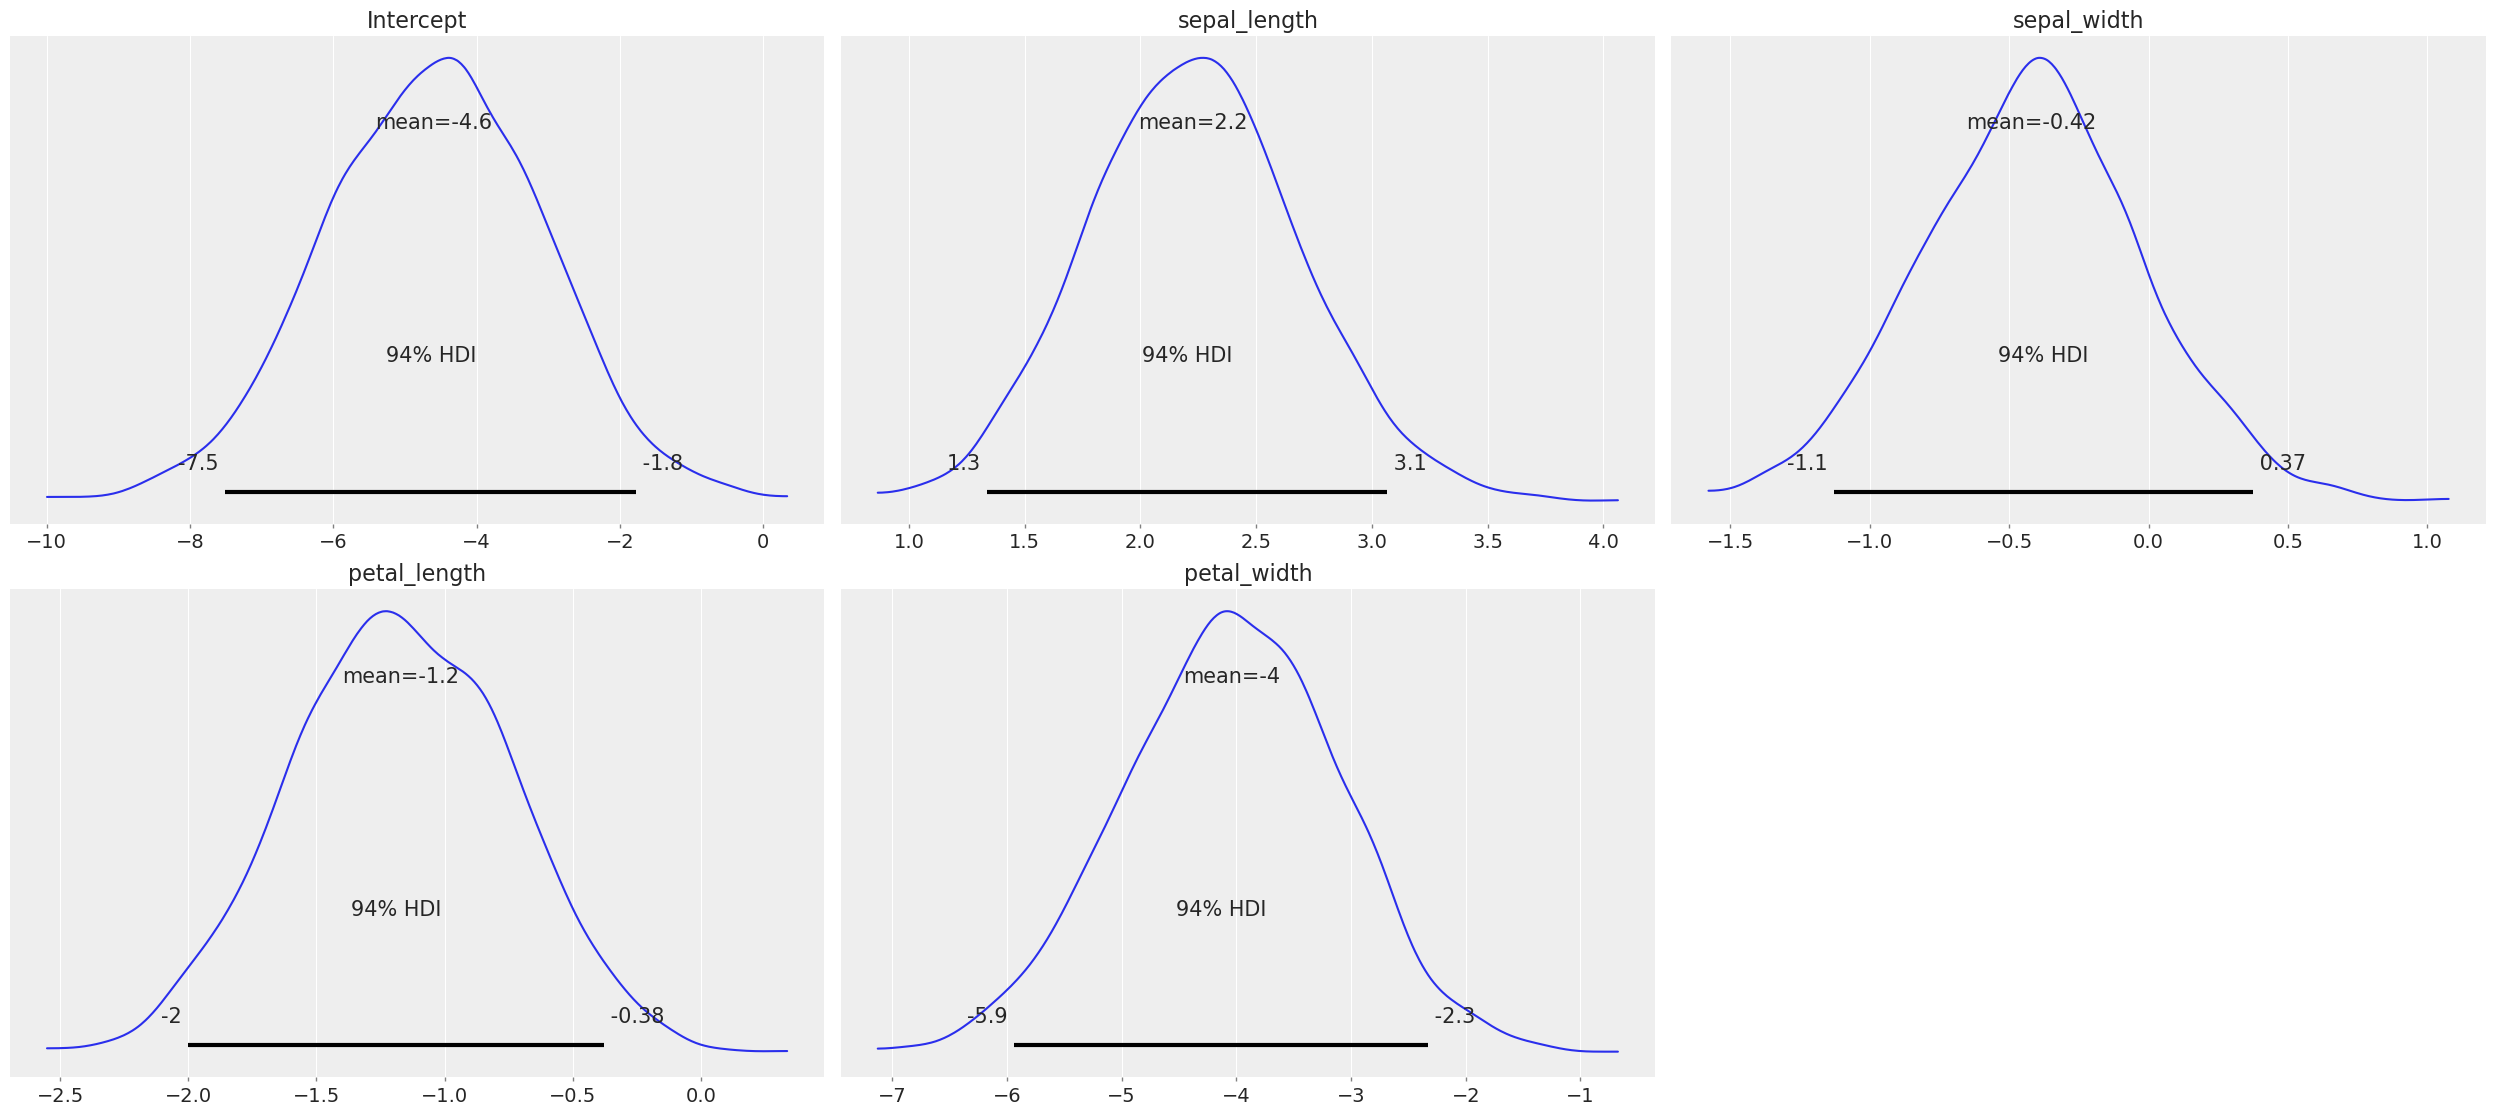

In [153]:
az.plot_posterior(idata, var_names=['Intercept','sepal_length','sepal_width','petal_length','petal_width']);

In [ ]:
bmb.interpret.plot_predictions(
    model,
    idata,
    ["length", "sex"],
    subplot_kwargs={"main": "length", "group": "estimate_dim", "panel": "sex"},
    fig_kwargs={"figsize": (12, 4)},
    legend=True
);

Here we can see that the larger male and female alligators are, the less of a taste they have for invertebrates, and far prefer fish. Additionally, males seem to have a higher propensity to consume "other" foods compared to females at any size. Of note, the posterior means predicted by Bambi contain information about all $n$ categories (despite having only $n-1$ coefficients), so we can directly construct this plot, rather than manually calculating $1-(p_1+p_2)$ for the third class.

Last, we can make a posterior predictive plot,

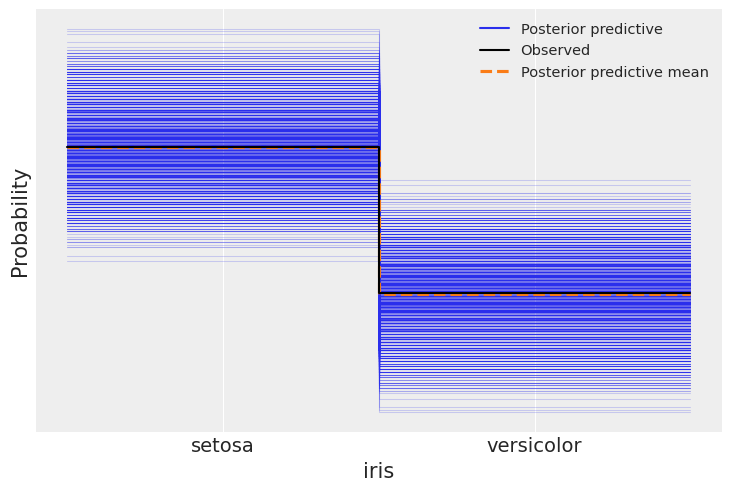

In [154]:
model.predict(idata, kind="pps")

ax = az.plot_ppc(idata)
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(model.response_component.term.levels)
ax.set_xlabel("iris");
ax.set_ylabel("Probability");

which depicts posterior predicted probability for each possible food choice for an alligator, which reinforces fish being the most likely food choice, followed by invertebrates.

In [155]:
# Predict probabilities for new data
predicted_params = model.predict(idata, kind='response_params', data=df_test, inplace=False)

# Extract the predicted probabilities
pred_probs = predicted_params.posterior['p']

# Calculate the mean predicted probabilities for each new observation
mean_pred_probs = pred_probs.mean(dim=['chain', 'draw']).values

y_pred = np.where(mean_pred_probs >=0.5,'setosa', 'versicolor')

In [156]:
dd=pd.DataFrame({'y':df_test['species'],'p':mean_pred_probs,'y_pred':y_pred})
dd

,y,p,y_pred
83,versicolor,0.008473,versicolor
91,versicolor,0.035729,versicolor
16,setosa,0.930999,setosa
61,versicolor,0.025174,versicolor
11,setosa,0.876449,setosa
...,...,...,...
3,setosa,0.853228,setosa
35,versicolor,0.950242,setosa
90,versicolor,0.032378,versicolor
26,setosa,0.832507,setosa


In [157]:
from sklearn.metrics import classification_report
target_names = ['versicolor', 'setosa']
print(classification_report(df_test['species'], y_pred, target_names=target_names))

              precision    recall  f1-score   support

  versicolor       0.91      0.92      0.92       495
      setosa       0.92      0.91      0.92       505

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [132]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data